## Exercise 2

Your boss was extremely happy with your work on the housing price prediction model and decided to entrust you with a more challenging task. They've seen a lot of people leave the company recently and they would like to understand why that's happening. They have collected historical data on employees and they would like you to build a model that is able to predict which employee will leave next. The would like a model that is better than random guessing. They also prefer false negatives than false positives, in this first phase. Fields in the dataset include:

- Employee satisfaction level
- Last evaluation
- Number of projects
- Average monthly hours
- Time spent at the company
- Whether they have had a work accident
- Whether they have had a promotion in the last 5 years
- Department
- Salary
- Whether the employee has left

Your goal is to predict the binary outcome variable `left` using the rest of the data. Since the outcome is binary, this is a classification problem. Here are some things you may want to try out:

1. load the dataset at ../data/HR_comma_sep.csv, inspect it with `.head()`, `.info()` and `.describe()`.
- Establish a benchmark: what would be your accuracy score if you predicted everyone stay?
- Check if any feature needs rescaling. You may plot a histogram of the feature to decide which rescaling method is more appropriate.
- convert the categorical features into binary dummy columns. You will then have to combine them with the numerical features using `pd.concat`.
- do the usual train/test split with a 20% test size
- play around with learning rate and optimizer
- check the confusion matrix, precision and recall
- check if you still get the same results if you use a 5-Fold cross validation on all the data
- Is the model good enough for your boss?

As you will see in this exercise, the a logistic regression model is not good enough to help your boss. In the next chapter we will learn how to go beyond linear models.

This dataset comes from https://www.kaggle.com/ludobenistant/hr-analytics/ and is released under [CC BY-SA 4.0 License](https://creativecommons.org/licenses/by-sa/4.0/).

In [144]:
import pandas as pd
from pandas.tools.plotting import scatter_matrix as smplot
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam, SGD
from keras.regularizers import l2

from sklearn.metrics import r2_score, accuracy_score, precision_score, f1_score, zero_one_loss, classification_report
from sklearn.model_selection import train_test_split

% matplotlib inline

In [46]:
df0 = pd.read_csv('../data/HR_comma_sep.csv')
df0.head(10)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
5,0.41,0.50,2,153,3,0,1,0,sales,low
6,0.10,0.77,6,247,4,0,1,0,sales,low
7,0.92,0.85,5,259,5,0,1,0,sales,low
8,0.89,1.00,5,224,5,0,1,0,sales,low
9,0.42,0.53,2,142,3,0,1,0,sales,low


In [47]:
jobs = df0.sales.unique()
# categorize jobs column
dfjob = pd.get_dummies(df['sales'], prefix='job')
df0 = df0.drop('sales', axis=1)
df0 = pd.concat([df0, dfjob], axis=1)
# categorize salary column
dfslry = pd.get_dummies(df['salary'], prefix='salary_level')
df0 = df0.drop('salary', axis=1)
df0 = pd.concat([df0, dfslry], axis=1)

In [48]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 21 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
job_IT                   14999 non-null uint8
job_RandD                14999 non-null uint8
job_accounting           14999 non-null uint8
job_hr                   14999 non-null uint8
job_management           14999 non-null uint8
job_marketing            14999 non-null uint8
job_product_mng          14999 non-null uint8
job_sales                14999 non-null uint8
job_support              14999 non-null uint8
job_technical            14999 non-null uint8
salary_level_high        14999 non-null uint8
salary_level_

In [50]:
df0.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,job_IT,job_RandD,...,job_hr,job_management,job_marketing,job_product_mng,job_sales,job_support,job_technical,salary_level_high,salary_level_low,salary_level_medium
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,...,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268,0.081805,0.052470,...,0.049270,0.042003,0.057204,0.060137,0.276018,0.148610,0.181345,0.082472,0.487766,0.429762
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281,0.274077,0.222981,...,0.216438,0.200602,0.232239,0.237749,0.447041,0.355715,0.385317,0.275092,0.499867,0.495059
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


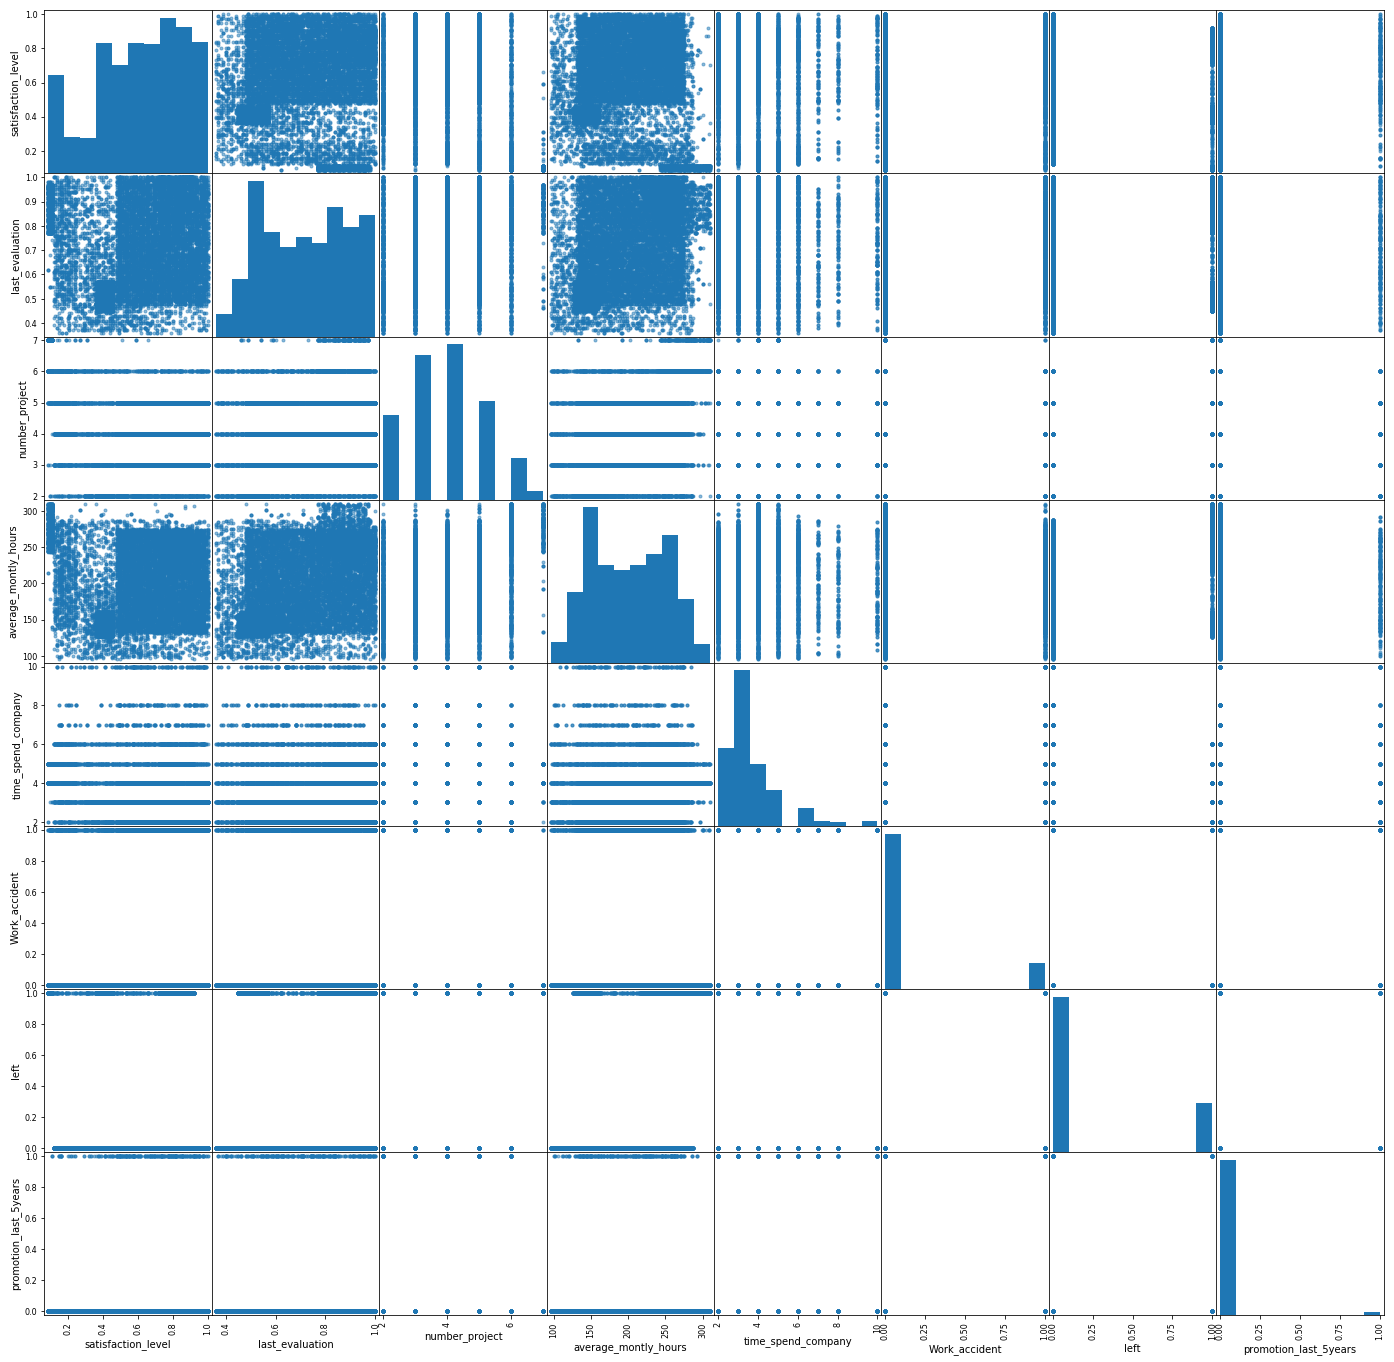

In [56]:
_ = smplot(df0.iloc[:, :8], figsize=(24, 24), diagonal='hist')

In [79]:
dffeature = df0.drop('left', axis=1)
X = dffeature.values
y = df0.left.values

### PCA for feature selection

In [84]:
from sklearn.decomposition import PCA

for n_comps in range(X.shape[1], 0, -1):
    pca = PCA(n_components = n_comps)
    pca.fit(X)
    
    print('======================== ', n_comps, ' components =========================')
    print('===== explained variance ratio: ===========================================')
    print(pca.explained_variance_ratio_)
    print('\n')
    
print('===== components: ===========================================')
print(pca.components_)

========================  20  components =========================
===== explained variance ratio: ===========================================
[  9.97999534e-01   8.69342838e-04   4.73823077e-04   1.82844960e-04
   9.48675250e-05   6.57917451e-05   4.97732563e-05   4.75824037e-05
   4.31762170e-05   2.95275424e-05   2.43750795e-05   2.35352048e-05
   2.19498321e-05   2.05957900e-05   1.99451143e-05   1.61590763e-05
   9.25180505e-06   7.92421462e-06   1.31224433e-35   2.30351794e-36]


========================  19  components =========================
===== explained variance ratio: ===========================================
[  9.97999534e-01   8.69342838e-04   4.73823077e-04   1.82844960e-04
   9.48675250e-05   6.57917451e-05   4.97732563e-05   4.75824037e-05
   4.31762170e-05   2.95275424e-05   2.43750795e-05   2.35352048e-05
   2.19498321e-05   2.05957900e-05   1.99451143e-05   1.61590763e-05
   9.25180505e-06   7.92421462e-06   1.31224433e-35]


========================  18  compo

### should do feature scaling first

In [81]:
dffeature.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,job_IT,job_RandD,job_accounting,job_hr,job_management,job_marketing,job_product_mng,job_sales,job_support,job_technical,salary_level_high,salary_level_low,salary_level_medium
count,14999.000000,14999.000000,1.499900e+04,1.499900e+04,1.499900e+04,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,5.589976e-17,-8.716572e-17,-6.063702e-17,0.144610,0.021268,0.081805,0.052470,0.051137,0.049270,0.042003,0.057204,0.060137,0.276018,0.148610,0.181345,0.082472,0.487766,0.429762
std,0.248631,0.171169,1.000033e+00,1.000033e+00,1.000033e+00,0.351719,0.144281,0.274077,0.222981,0.220284,0.216438,0.200602,0.232239,0.237749,0.447041,0.355715,0.385317,0.275092,0.499867,0.495059
min,0.090000,0.360000,-1.462863e+00,-2.103471e+00,-1.026126e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,-6.515376e-01,-9.020633e-01,-3.412352e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,1.597876e-01,-2.103137e-02,-3.412352e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,9.711129e-01,8.800240e-01,3.436553e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,2.593763e+00,2.181549e+00,4.452998e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [80]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

dffeature.iloc[:,2:5] = ss.fit_transform(dffeature.iloc[:,2:5])

In [82]:
dffeature.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,job_IT,job_RandD,job_accounting,job_hr,job_management,job_marketing,job_product_mng,job_sales,job_support,job_technical,salary_level_high,salary_level_low,salary_level_medium
count,14999.000000,14999.000000,1.499900e+04,1.499900e+04,1.499900e+04,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,5.589976e-17,-8.716572e-17,-6.063702e-17,0.144610,0.021268,0.081805,0.052470,0.051137,0.049270,0.042003,0.057204,0.060137,0.276018,0.148610,0.181345,0.082472,0.487766,0.429762
std,0.248631,0.171169,1.000033e+00,1.000033e+00,1.000033e+00,0.351719,0.144281,0.274077,0.222981,0.220284,0.216438,0.200602,0.232239,0.237749,0.447041,0.355715,0.385317,0.275092,0.499867,0.495059
min,0.090000,0.360000,-1.462863e+00,-2.103471e+00,-1.026126e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,-6.515376e-01,-9.020633e-01,-3.412352e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,1.597876e-01,-2.103137e-02,-3.412352e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,9.711129e-01,8.800240e-01,3.436553e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,2.593763e+00,2.181549e+00,4.452998e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [163]:
X = dffeature.values

### do PCA again

In [164]:
stopping_variance = 0.95 # stopping criteria
for n_comps in range(X.shape[1], 0, -1):
    pca = PCA(n_components = n_comps)
    pca.fit(X)
    if sum(pca.explained_variance_ratio_) >= stopping_variance:
        pca_sv = pca
    
    print('======================== ', n_comps, ' components =========================')
    print('===== explained variance ratio: ===========================================')
    print(pca.explained_variance_ratio_)
    print('\n')
    print("total variance explained: {:0.3f}".format(sum(pca.explained_variance_ratio_)))
    print('\n')

========================  20  components =========================
===== explained variance ratio: ===========================================
[  3.27878050e-01   1.95000057e-01   1.24071661e-01   9.81812308e-02
   5.09566149e-02   3.53485973e-02   2.67422105e-02   2.55568736e-02
   2.31983493e-02   1.58645338e-02   1.30853374e-02   1.26442883e-02
   1.17932476e-02   1.10656420e-02   1.07162373e-02   8.67959679e-03
   4.96001542e-03   4.25745676e-03   3.77508942e-33   1.39687060e-33]


total variance explained: 1.000


========================  19  components =========================
===== explained variance ratio: ===========================================
[  3.27878050e-01   1.95000057e-01   1.24071661e-01   9.81812308e-02
   5.09566149e-02   3.53485973e-02   2.67422105e-02   2.55568736e-02
   2.31983493e-02   1.58645338e-02   1.30853374e-02   1.26442883e-02
   1.17932476e-02   1.10656420e-02   1.07162373e-02   8.67959679e-03
   4.96001542e-03   4.25745676e-03   3.77508942e-33]


t

In [166]:
dffeature.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident',
       'promotion_last_5years', 'job_IT', 'job_RandD', 'job_accounting',
       'job_hr', 'job_management', 'job_marketing', 'job_product_mng',
       'job_sales', 'job_support', 'job_technical', 'salary_level_high',
       'salary_level_low', 'salary_level_medium'],
      dtype='object')

In [172]:
print('===== components: Scaled by 1e2 times ===========================================')
col = dffeature.columns.tolist()
components = pd.DataFrame(np.multiply(pca_sv.components_, 1e2), columns=col)
components

===== components: Scaled by 1e2 times ===========================================


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,job_IT,job_RandD,job_accounting,job_hr,job_management,job_marketing,job_product_mng,job_sales,job_support,job_technical,salary_level_high,salary_level_low,salary_level_medium
0,-2.489580,5.687919,66.011175,62.947015,40.485679,-0.226847,0.205624,0.077745,-0.043007,0.074241,-0.493491,0.731634,-0.244273,-0.074316,-0.145840,-0.349194,0.466501,0.118249,-0.841587,0.723338
1,-1.622653,-1.520694,-18.911640,-38.228031,90.242313,0.302065,1.084612,-0.285327,-0.515646,0.081300,-0.250791,2.421302,0.520013,-0.042606,1.211012,-1.240720,-1.898536,1.457454,-3.442665,1.985212
2,-3.717811,0.168409,72.407991,-67.503549,-13.327264,0.196033,-0.325962,-0.071662,0.450213,0.104642,-0.389441,-0.358143,-0.569267,0.231932,-1.470527,0.528445,1.543808,-0.439538,1.392625,-0.953087
3,-1.907331,0.056268,-1.286973,0.362774,4.154731,-0.355455,-1.373917,-0.091740,-0.751486,-0.304311,-0.861263,-0.806547,-0.321874,0.097452,1.671645,0.752457,0.615667,-0.924529,71.060077,-70.135548
4,0.174077,-0.746004,2.034983,-0.408393,-1.992358,-0.608163,0.717854,-6.518498,-3.436047,-3.441216,-3.235145,-3.123754,-4.060335,-4.225145,88.551053,-20.659645,-39.851266,-2.840106,0.640119,2.199987
5,1.068269,0.627421,0.875562,0.103520,-0.229422,4.238706,0.156171,6.711211,3.259302,3.031720,2.808065,2.408075,3.627381,3.938390,-16.747558,64.585055,-73.621642,0.527211,0.022197,-0.549408
6,8.534984,0.101424,0.523678,0.297800,-0.446211,97.710723,2.770537,-2.444618,1.708774,-1.240965,-1.925611,4.038980,1.663071,0.120572,0.988344,-4.557906,1.649360,14.448886,-6.651933,-7.796953
7,2.115870,-1.043738,1.106718,0.186389,-2.498428,-16.793928,3.997163,16.795602,5.489687,7.942025,5.021301,19.228454,8.895377,8.363490,-12.590509,-34.963628,-24.181800,67.329069,-32.241451,-35.087618
8,2.241340,0.003012,-0.130839,0.049764,-0.035903,-8.496669,1.063887,-44.344689,-13.783402,-11.168983,-12.104417,2.004359,-14.406932,-17.375876,23.606647,53.333634,34.239659,40.048389,-20.534359,-19.514030
9,5.662707,0.556528,-0.081867,-0.386042,0.555881,1.130539,-2.984174,80.521012,-19.564185,-17.637243,-16.252464,-6.525252,-26.391738,-34.158616,10.860004,15.780112,13.368370,6.501864,-3.686882,-2.814982


### create a logistic regression modelling function

In [207]:
def CreateLogRegModel(A, B, C, D, opt, lossfunc, epos, reg=None, callbacks=None, cvsplit = 0.0):

    model = Sequential()
    model.add(Dense(1, input_dim=A.shape[1], kernel_regularizer = reg))
    model.add(Activation('sigmoid'))
    model.compile(optimizer = opt, loss = lossfunc)
    print('The initial weights W are: \n', model.get_weights()[0])
    print('The initial bias b is: ', model.get_weights()[1])
    print('---------------------------------------------------------------')

    RunModel(A, B, C, D, model, cvsplit, epos, callbacks)
    
def RunModel(A, B, C, D, model, cvsplit, epos, callbacks):
    history = model.fit(A, B, validation_split = cvsplit, epochs = epos, verbose=0, callbacks = callbacks)

#     print('The resulted weights W are: \n', model.get_weights()[0])
#     print('The resulted bias b is: ', model.get_weights()[1])
#     print('--------------------------- plot the loss function ------------------------------------')
    
    N_epo = len(history.history['loss'])
    plt.figure(figsize=(16,5))
    plt.plot(np.linspace(1, N_epo, N_epo), history.history['loss'], c='g', label='training set loss')
    if cvsplit > 0.:
        plt.plot(np.linspace(1, N_epo, N_epo), history.history['val_loss'], c='r', label='CV set loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
#     Nticks = N_epo+1 if(N_epo < 40) else 21
    plt.xticks(np.linspace(0, N_epo, N_epo+1 if(N_epo < 40) else 21))
    plt.legend()
    plt.grid()
    plt.show()
    print('----------------------------- Accuracy Score ----------------------------------')
    print("Training set: {:0.3f}".format(accuracy_score(B, model.predict(A).round())))
    print("Testing set: {:0.3f}".format(accuracy_score(D, model.predict(C).round())))
    print('----------------------------- Misclassification Rate ----------------------------------')
    print("Training set: {:0.3f}".format(zero_one_loss(B, model.predict(A).round())))
    print("Testing set: {:0.3f}".format(zero_one_loss(D, model.predict(C).round())))
    print('----------------------------- Classification Report ----------------------------------')
    print("Training set:", classification_report(B, model.predict(A).round()))
    print("Testing set:", classification_report(D, model.predict(C).round()))

    plt.scatter(A[:,0], B, c='blue', label='real', alpha=0.8)
    plt.scatter(A[:,0], model.predict(A).round(), c='red', label='prediction', alpha=0.2)
    plt.legend()
    plt.grid()
    plt.show()

### use the PCA result to do a logistic regression on the data set

In [176]:
X_1pca = pca_sv.transform(X)
A, C, B, D = train_test_split(X_1pca, y, test_size=0.1)

In [178]:
import scipy
scipy.stats.describe(X_1pca)

DescribeResult(nobs=14999, minmax=(array([-2.67760192, -1.93727749, -2.64501963, -0.83870259, -0.64211036,
       -0.70343408, -0.26081599, -0.60266653, -0.71691862, -0.46984619,
       -0.68520734, -0.77139405, -0.65537685]), array([ 3.8781322 ,  4.90470704,  2.75028623,  0.88054643,  0.8350767 ,
        0.77123211,  1.11000338,  1.29330917,  0.97244772,  0.84405419,
        0.70356818,  0.88781932,  0.70508476])), mean=array([ -9.13404369e-17,   3.83267138e-16,  -2.48077370e-17,
         1.38690905e-16,   2.10808399e-17,   1.57514141e-17,
         2.92859350e-17,   6.76578009e-17,   1.30644952e-17,
         1.30843880e-17,   1.10034138e-16,  -3.64593792e-17,
        -1.21864353e-17]), variance=array([ 1.52536183,  0.90718377,  0.57720904,  0.45676099,  0.23706154,
        0.16444956,  0.12441073,  0.11889628,  0.1079239 ,  0.07380535,
        0.06087591,  0.05882405,  0.05486482]), skewness=array([  3.30078450e-01,   1.58411708e+00,   1.93006750e-01,
        -1.12154550e-01,   7.6702

The initial weights W are: 
 [[ 0.37178183]
 [ 0.25967485]
 [ 0.53132594]
 [-0.61898577]
 [-0.36211476]
 [ 0.43665969]
 [ 0.37378418]
 [-0.61771524]
 [ 0.40703177]
 [-0.07661313]
 [ 0.62377167]
 [ 0.33234936]
 [ 0.01134747]]
The initial bias b is:  [ 0.]
---------------------------------------------------------------
The resulted weights W are: 
 [[ 0.45414981]
 [-0.02043863]
 [-0.04898265]
 [ 0.28094283]
 [-0.03247915]
 [-0.01089772]
 [-0.51097584]
 [-0.54966033]
 [ 0.10777373]
 [-0.05445587]
 [-1.13354325]
 [ 0.27147609]
 [ 0.34890765]]
The resulted bias b is:  [-1.29359007]
--------------------------- plot the loss function ------------------------------------


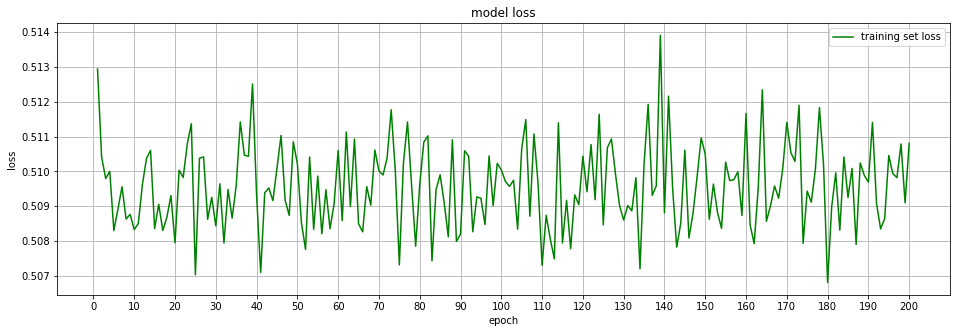

----------------------------- Accuracy Score ----------------------------------
(13499,)
(13499, 1)
Training set: 0.807
Testing set: 0.799
----------------------------- Misclassification Rate ----------------------------------
Training set: 0.193
Testing set: 0.201
----------------------------- Classification Report ----------------------------------
Training set:              precision    recall  f1-score   support

          0       0.81      0.99      0.89     10299
          1       0.83      0.23      0.37      3200

avg / total       0.81      0.81      0.76     13499

Testing set:              precision    recall  f1-score   support

          0       0.79      0.99      0.88      1129
          1       0.87      0.22      0.35       371

avg / total       0.81      0.80      0.75      1500



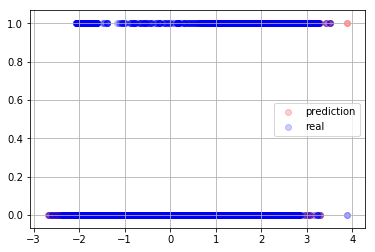

In [185]:
opt = Adam(lr=0.1)
lossfunc = 'binary_crossentropy'
epos = 200
reg = l2(0.01)
cbacks = None
cvsplit = 0.
CreateLogRegModel(A, B, C, D, opt, lossfunc, epos, reg=reg, callbacks=cbacks, cvsplit=cvsplit)

## 0 (hidden) layer neural network, should be the same as the above logistic regression model

In [228]:
def CreateDNNModel(input_dim, epos, opt=Adam(lr=0.1), lossfunc = 'binary_crossentropy', metrics = None,
                   hidden_nodes=[1], activators = ['sigmoid'], reg=None, callbacks=None, cvsplit = 0.0, verbose=1):
    
    model = Sequential()
    NNlayout = zip(hidden_nodes, activators)
    for i_layer, layerparam in enumerate(NNlayout):
        if i_layer == 0:
            model.add(Dense(layerparam[0], input_dim=input_dim, kernel_regularizer = reg))
        else:
            model.add(Dense(layerparam[0], kernel_regularizer = reg))
        model.add(Activation(layerparam[1]))
    if verbose:
        print(model.summary())    
    model.compile(optimizer = opt, loss = lossfunc, metrics=metrics)
#     print('The initial weights W are: \n', model.get_weights()[0])
#     print('The initial bias b is: ', model.get_weights()[1])
#     print('---------------------------------------------------------------')
    return model


The initial weights W are: 
 [[-0.48336631]
 [-0.26908591]
 [ 0.35774469]
 [ 0.38755465]
 [ 0.35092592]
 [ 0.25347167]
 [-0.33692351]
 [-0.20573848]
 [-0.16217691]
 [ 0.22008473]
 [-0.34334189]
 [ 0.24257517]
 [-0.16466811]]
The initial bias b is:  [ 0.]
---------------------------------------------------------------
The resulted weights W are: 
 [[ 0.26136959]
 [ 0.23212932]
 [-0.07187645]
 [ 0.34111232]
 [-0.29180562]
 [-0.15859057]
 [-1.03958356]
 [-0.10591847]
 [-0.16290832]
 [-0.23142366]
 [-1.54887331]
 [ 0.27126974]
 [ 0.3027629 ]]
The resulted bias b is:  [-1.18389297]
--------------------------- plot the loss function ------------------------------------


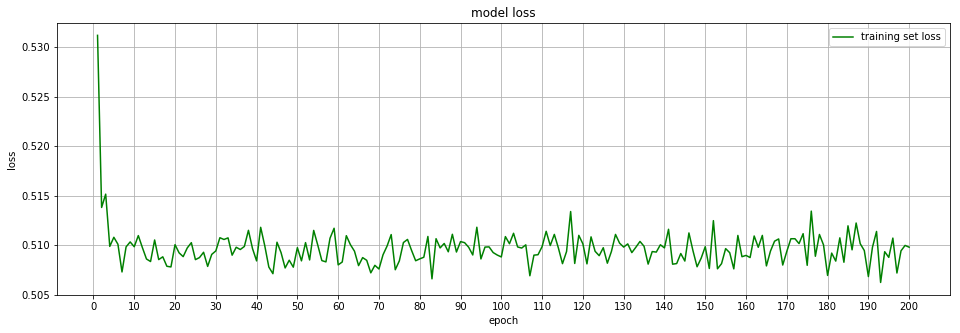

----------------------------- Accuracy Score ----------------------------------
Training set: 0.782
Testing set: 0.773
----------------------------- Misclassification Rate ----------------------------------
Training set: 0.218
Testing set: 0.227
----------------------------- Classification Report ----------------------------------
Training set:              precision    recall  f1-score   support

          0       0.79      0.96      0.87     10299
          1       0.62      0.20      0.30      3200

avg / total       0.75      0.78      0.74     13499

Testing set:              precision    recall  f1-score   support

          0       0.78      0.97      0.87      1129
          1       0.65      0.18      0.28       371

avg / total       0.75      0.77      0.72      1500



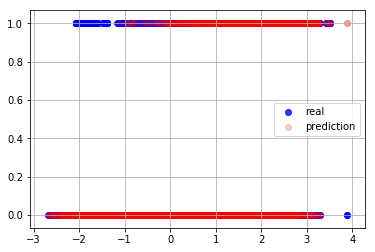

In [195]:
epos = 20
reg = l2(0.01)
model = CreateDNNModel(A.shape[1], epos, reg=reg)
RunModel(A, B, C, D, model, cvsplit, epos, cbacks)

## one layer Neural Network

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 20)                280       
_________________________________________________________________
activation_50 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 21        
_________________________________________________________________
activation_51 (Activation)   (None, 1)                 0         
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________
None


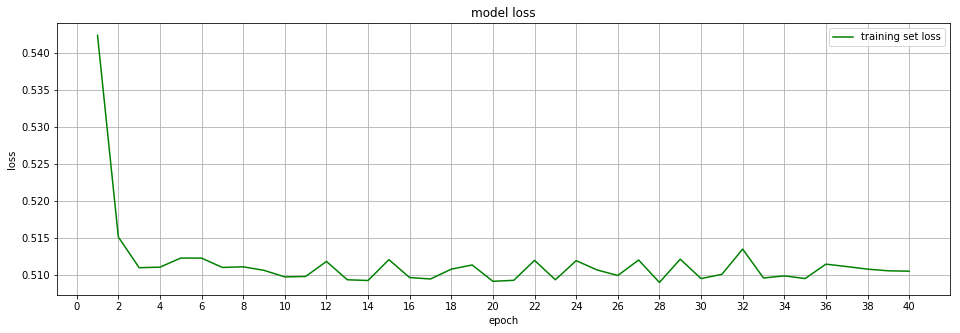

----------------------------- Accuracy Score ----------------------------------
Training set: 0.836
Testing set: 0.835
----------------------------- Misclassification Rate ----------------------------------
Training set: 0.164
Testing set: 0.165
----------------------------- Classification Report ----------------------------------
Training set:              precision    recall  f1-score   support

          0       0.84      0.96      0.90     10299
          1       0.78      0.42      0.55      3200

avg / total       0.83      0.84      0.82     13499

Testing set:              precision    recall  f1-score   support

          0       0.84      0.97      0.90      1129
          1       0.81      0.43      0.56       371

avg / total       0.83      0.83      0.82      1500



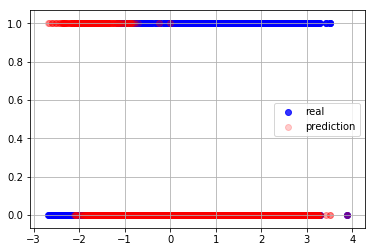

In [220]:
hidden_nodes=[20, 1]
activators = ['relu','sigmoid']
epos = 40

model = CreateDNNModel(A.shape[1], epos, reg=reg, 
                       hidden_nodes=hidden_nodes, activators=activators)
RunModel(A, B, C, D, model, cvsplit, epos, cbacks)

In [232]:
epos = 25
def createModel():
    model = CreateDNNModel(A.shape[1], epos, reg=reg, 
                           hidden_nodes=hidden_nodes, activators=activators, verbose=0)
    return model

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, KFold

hidden_nodes=[20, 1]
activators = ['relu','sigmoid']

model = KerasClassifier(build_fn=createModel,
                        epochs=25,
                        verbose=0)

scores = cross_val_score(model, A, B, cv = KFold(5, shuffle=True))

print("The cross validation accuracy is {:0.4f} ± {:0.4f}".format(scores.mean(), scores.std()))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_67 (Dense)             (None, 20)                280       
_________________________________________________________________
activation_65 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_68 (Dense)             (None, 1)                 21        
_________________________________________________________________
activation_66 (Activation)   (None, 1)                 0         
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 20)                280       
_________________________________________________________________
activat

## DNN

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_77 (Dense)             (None, 10)                140       
_________________________________________________________________
activation_75 (Activation)   (None, 10)                0         
_________________________________________________________________
dense_78 (Dense)             (None, 10)                110       
_________________________________________________________________
activation_76 (Activation)   (None, 10)                0         
_________________________________________________________________
dense_79 (Dense)             (None, 1)                 11        
_________________________________________________________________
activation_77 (Activation)   (None, 1)                 0         
Total params: 261
Trainable params: 261
Non-trainable params: 0
_________________________________________________________________
None


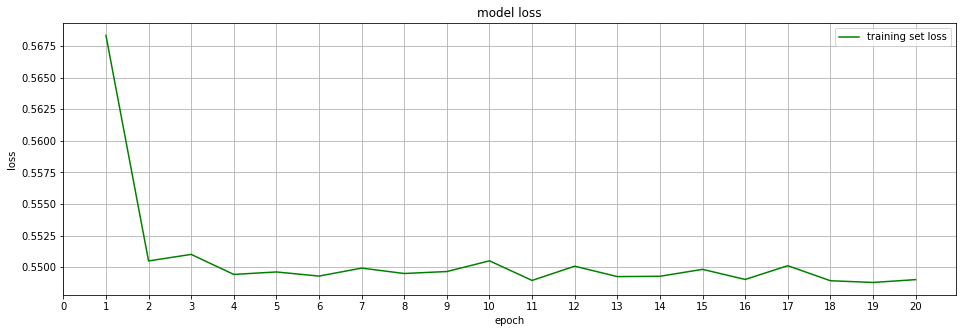

----------------------------- Accuracy Score ----------------------------------
Training set: 0.763
Testing set: 0.753
----------------------------- Misclassification Rate ----------------------------------
Training set: 0.237
Testing set: 0.247
----------------------------- Classification Report ----------------------------------
Training set:              precision    recall  f1-score   support

          0       0.76      1.00      0.87     10299
          1       0.00      0.00      0.00      3200

avg / total       0.58      0.76      0.66     13499

Testing set:              precision    recall  f1-score   support

          0       0.75      1.00      0.86      1129
          1       0.00      0.00      0.00       371

avg / total       0.57      0.75      0.65      1500



/Users/apalumbo/anaconda/envs/ztdl/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


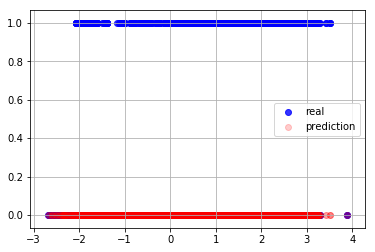

In [233]:
hidden_nodes=[10, 10, 1]
activators = ['relu', 'relu', 'sigmoid']
epos = 20

model = CreateDNNModel(A.shape[1], epos, reg=reg, 
                       hidden_nodes=hidden_nodes, activators=activators)
RunModel(A, B, C, D, model, cvsplit, epos, cbacks)